# NBA 1990-1991 Season Analysis

# Imports

In [12]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



import psycopg2
from dotenv import load_dotenv

from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score


# Models

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Constants

In [4]:
dotenv_path = ("/Users/maukanmir/Documents/Machine-Learning/NBA Projects/1990-1991-Season-Analysis/dot.env")
load_dotenv(dotenv_path)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
TABLE_NAME = "salaries_and_stats"

In [9]:
conn = psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    port=DB_PORT
)

query = f"SELECT * FROM {TABLE_NAME} where season = '1990-1991';"
df = pd.read_sql_query(query, conn)

conn.close()

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [10]:
df

,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,3PM,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,2500000.0,Michael Jordan,CHI,82,37.0,31.5,12.1,22.4,0.539,0.4,...,8.2,0.851,1.4,4.6,6.0,5.5,2.7,1.0,2.5,1990-1991
1,2260000.0,Karl Malone,UTA,82,40.3,29.0,10.3,19.6,0.527,0.0,...,10.8,0.770,2.9,8.9,11.8,3.3,1.1,1.0,3.0,1990-1991
2,1600000.0,Bernard King,WAS,64,37.5,28.4,11.1,23.6,0.472,0.1,...,7.6,0.790,1.8,3.2,5.0,4.6,0.9,0.3,4.0,1990-1991
3,2900000.0,Charles Barkley,PHI,67,37.3,27.6,9.9,17.4,0.570,0.7,...,9.8,0.722,3.9,6.3,10.1,4.2,1.6,0.5,3.1,1990-1991
4,4250000.0,Patrick Ewing,NYK,81,38.3,26.6,10.4,20.3,0.514,0.0,...,7.7,0.745,2.4,8.8,11.2,3.0,1.0,3.2,3.6,1990-1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,550000.0,Larry Drew,LAL,48,10.3,2.9,1.1,2.6,0.432,0.3,...,0.5,0.773,0.1,0.6,0.7,2.5,0.3,0.0,1.0,1990-1991
239,575000.0,Elden Campbell,LAL,52,7.3,2.8,1.1,2.4,0.455,0.0,...,0.9,0.653,0.8,1.1,1.8,0.2,0.2,0.7,0.3,1990-1991
240,150000.0,Scott Williams,CHI,51,6.6,2.5,1.0,2.0,0.510,0.0,...,0.5,0.714,0.8,1.1,1.9,0.3,0.2,0.3,0.5,1990-1991
241,1100000.0,Wayne Cooper,POR,67,11.1,2.2,0.9,2.2,0.393,0.0,...,0.6,0.786,0.8,2.0,2.8,0.3,0.1,0.9,0.3,1990-1991


# Functions

In [13]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def create_sklearn_pipeline(model, kbest=None):
  steps = [
    ("Scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("Model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return create_sklearn_pipeline(steps=steps)


# EDA Analysis

In [14]:
check_for_nulls_dupes(df)

The amount of Null Values: salary    0
Name      0
Team      0
GP        0
MPG       0
PPG       0
FGM       0
FGA       0
FG%       0
3PM       0
3PA       0
3P%       0
FTM       0
FTA       0
FT%       0
ORB       0
DRB       0
RPG       0
APG       0
SPG       0
BPG       0
TOV       0
season    0
dtype: int64
The amount of Duplicated Values 0


In [15]:
df.dtypes

salary    float64
Name       object
Team       object
GP          int64
MPG       float64
PPG       float64
FGM       float64
FGA       float64
FG%       float64
3PM       float64
3PA       float64
3P%       float64
FTM       float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
RPG       float64
APG       float64
SPG       float64
BPG       float64
TOV       float64
season     object
dtype: object

In [16]:
df.describe()

,salary,GP,MPG,PPG,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV
count,2.430000e+02,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,9.614403e+05,74.300412,25.636626,11.393004,4.433333,9.283128,0.473831,0.241975,0.751852,0.203062,2.288066,2.975309,0.751329,1.467901,3.129630,4.600000,2.683128,0.913169,0.564609,1.667078
std,6.637036e+05,7.726489,8.888419,6.244289,2.365349,4.757925,0.044221,0.385865,1.093305,0.153527,1.588668,1.930649,0.096562,0.929875,1.903202,2.718562,2.348589,0.557807,0.629100,0.807702
min,5.000000e+04,48.000000,6.600000,1.900000,0.800000,2.000000,0.373000,0.000000,0.000000,0.000000,0.100000,0.400000,0.240000,0.100000,0.400000,0.600000,0.200000,0.000000,0.000000,0.300000
25%,4.825000e+05,70.000000,17.900000,5.850000,2.400000,5.000000,0.439500,0.000000,0.100000,0.000000,1.100000,1.500000,0.700000,0.750000,1.750000,2.600000,1.100000,0.500000,0.200000,1.000000
50%,8.250000e+05,76.000000,25.900000,10.600000,4.200000,8.600000,0.472000,0.100000,0.300000,0.240000,1.900000,2.600000,0.759000,1.300000,2.700000,3.900000,1.900000,0.800000,0.300000,1.600000
75%,1.265000e+06,81.000000,33.350000,15.750000,6.000000,12.500000,0.499000,0.300000,1.050000,0.333000,3.100000,4.000000,0.819000,2.100000,4.250000,6.350000,3.600000,1.200000,0.700000,2.100000
max,4.250000e+06,82.000000,40.400000,31.500000,12.100000,23.600000,0.647000,2.500000,8.500000,0.667000,8.300000,10.800000,0.963000,4.500000,9.800000,13.800000,14.200000,3.000000,3.900000,4.000000


In [17]:
numeric_cols = df.select_dtypes(include=["float64", "int64"])

<AxesSubplot:>

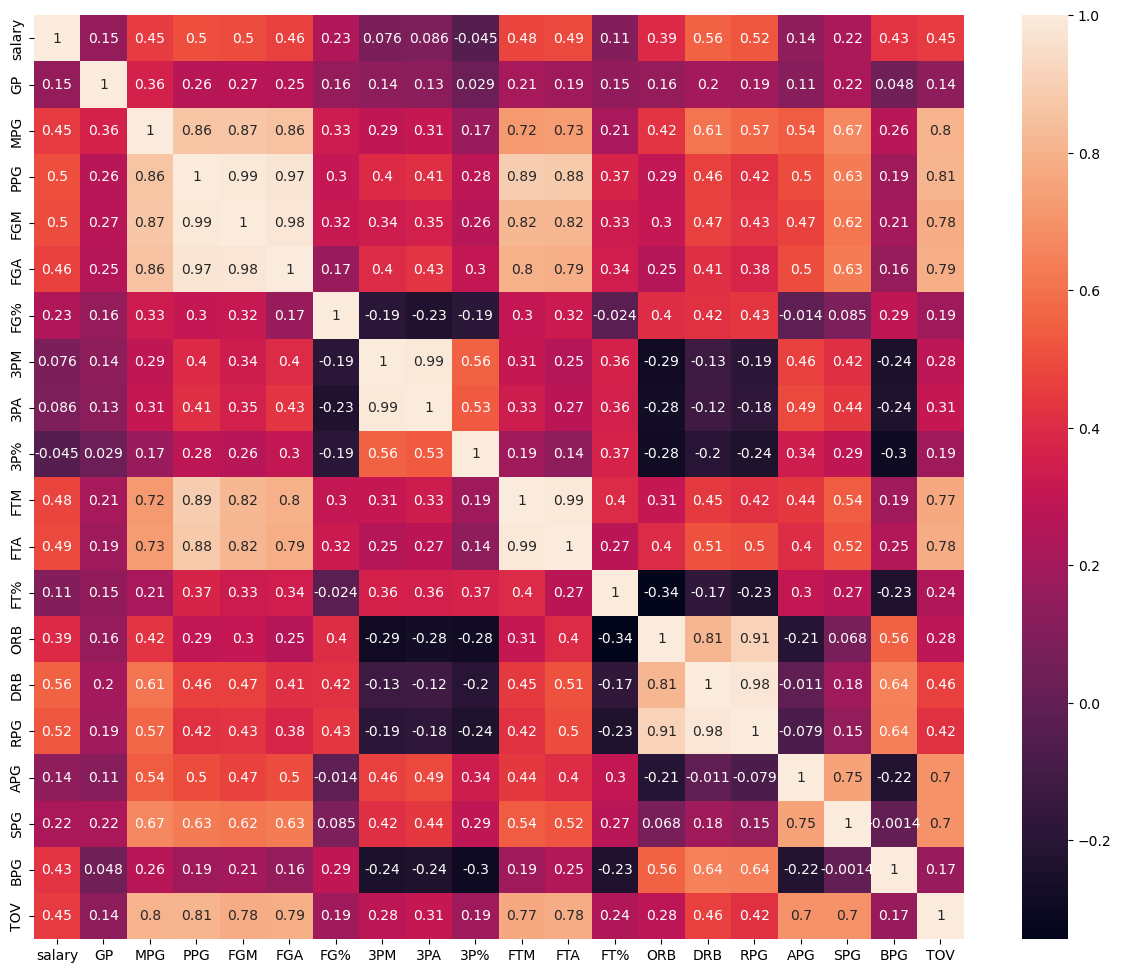

In [18]:
relations = numeric_cols.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(data=relations, annot=True)

# Check Distributions

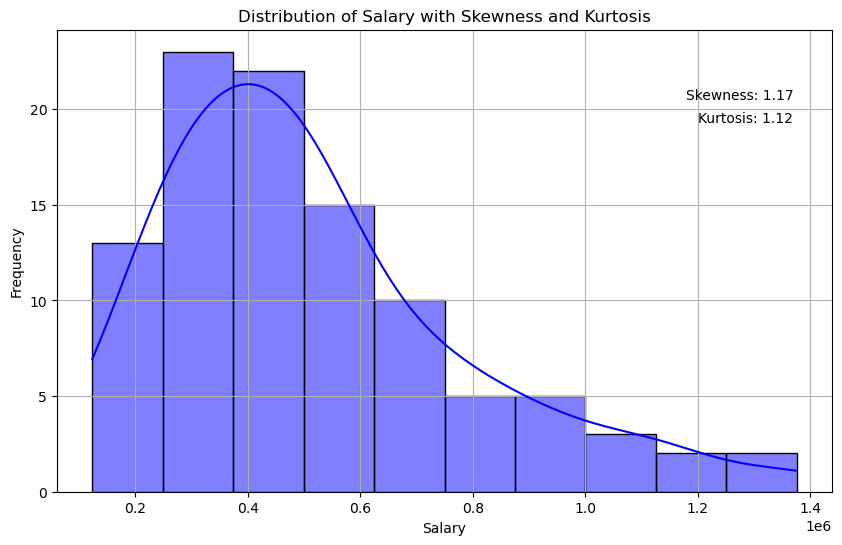

In [27]:
salary_skewness = df['salary'].skew()
salary_kurtosis = df['salary'].kurtosis()

plt.figure(figsize=(10, 6))
sns.histplot(df['salary'], kde=True, color='blue')
plt.title('Distribution of Salary with Skewness and Kurtosis')
plt.xlabel('Salary')
plt.ylabel('Frequency')

plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

plt.grid(True)

plt.show()

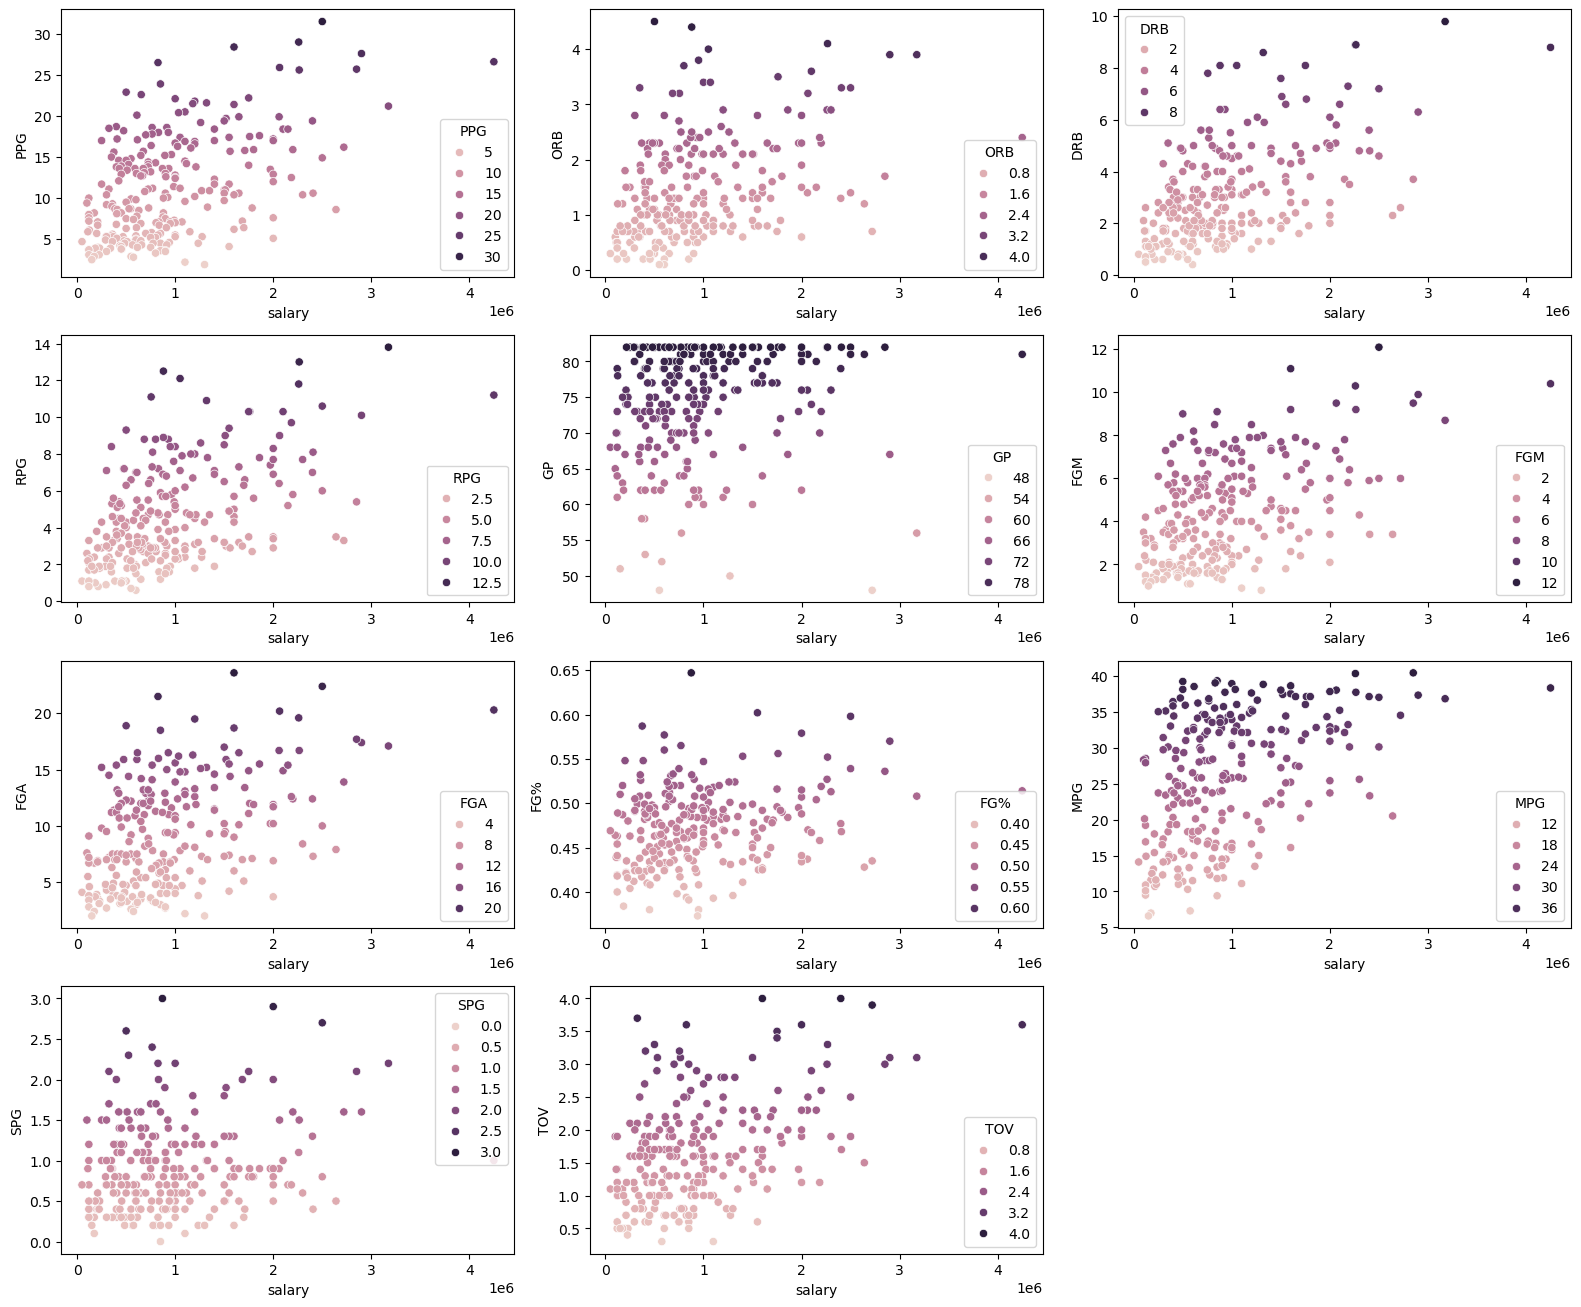

In [35]:
interested_columns = ["PPG", "ORB", "DRB", "RPG", "GP", "FGM", "FGA", "FG%", "MPG", "SPG", "TOV"]
plt.figure(figsize=(16,16))
rows = len(interested_columns)
dims = (rows+4)//3
for idx, col in enumerate(interested_columns):
  plt.subplot(dims, 3, idx+1)
  sns.scatterplot(numeric_cols, x="salary", y=col, hue=col)
plt.tight_layout()
plt.show()